In [1]:
import fnmatch
import os
import pandas as pd
from os.path import isfile, join
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

In [2]:
data_directory =  "/media/Carol/Magnetic/Experiments/Colloidal_Ice/Cairo_lattice/29-03-2022/Processed_vid"

In [3]:
Cairo = []
for file in os.listdir(data_directory):
    if fnmatch.fnmatch(file, "vertices_h=3_w=2_Exp*.dat"):
        print(file)
        Cairo.append(pd.read_csv(join(data_directory,file), sep = "\t", index_col = [0,1])) 
        
keys_Cairo = []
for i in range(len(Cairo)):
    keys_Cairo.append(i)

vertices_h=3_w=2_Exp8.dat
vertices_h=3_w=2_Exp7.dat
vertices_h=3_w=2_Exp1.dat
vertices_h=3_w=2_Exp3.dat
vertices_h=3_w=2_Exp2.dat
vertices_h=3_w=2_Exp5.dat
vertices_h=3_w=2_Exp4.dat
vertices_h=3_w=2_Exp6.dat
vertices_h=3_w=2_Exp0.dat


In [4]:
Cairo_exp = pd.concat(Cairo, keys = keys_Cairo)
Cairo_exp.index.names = ['Exp', 'frame', 'id']

In [5]:
Cairo_exp = Cairo_exp.query('coordination != 2')


In [6]:
Cairo_exp["type"] = np.NaN

# 4-fold vertices classification

Cairo_exp.loc[Cairo_exp.charge==-4, "type"] = "Q = -4"
Cairo_exp.loc[Cairo_exp.charge==-2, "type"] = "Q = -2"
Cairo_exp.loc[Cairo_exp.charge==+2, "type"] = "Q = +2"
Cairo_exp.loc[Cairo_exp.charge==+4, "type"] = "Q = +4"

zeroq = Cairo_exp.charge==0

dipole_magnitude = np.sqrt(Cairo_exp[zeroq].dx**2+Cairo_exp[zeroq].dy**2)

Cairo_exp.loc[zeroq & (dipole_magnitude<1), "type"] = "Q = 0"
Cairo_exp.loc[zeroq & (dipole_magnitude>2) , "type"] = "Q = 0"

# 3-fold vertices classification

Cairo_exp.loc[Cairo_exp.charge==+1, "type"] = "Q = +1"
Cairo_exp.loc[Cairo_exp.charge==-1, "type"] = "Q = -1"
Cairo_exp.loc[Cairo_exp.charge==+3, "type"] = "Q = +3"
Cairo_exp.loc[Cairo_exp.charge==-3, "type"] = "Q = -3"

In [7]:
Cairo_exp

x           y  coordination  charge        dx  \
Exp frame id                                                           
0   0     0   160.794289  161.205711             4      -2  1.000000   
          1   239.592657  240.004080             4       2 -1.732051   
          2   121.395105  183.990965             3       1 -1.732051   
          3   216.807403  200.604895             3       1  1.000000   
          4   239.590240  161.196691             4      -4  0.000000   
...                  ...         ...           ...     ...       ...   
8   3700  29  260.377911  277.403264             3       1  2.000000   
          30   79.998337   80.398323             4       0  0.732051   
          31  158.784758   80.401840             4       0  0.000000   
          32  293.605771  277.403264             3       1  1.000000   
          33  316.384983  316.824999             4       0  0.000000   

                    dy    type  
Exp frame id                    
0   0     0   1.732051  Q = -2  
          1   1.000000  Q = +2  
          2  -1.000000  Q = +1  
          3   1.732051  Q = +1  
          4   0.000000  Q = -4  
...                ...     ...  
8   3700  29  0.000000  Q = +1  
          30 -2.732051   Q = 0  
          31  0.000000   Q = 0  
          32 -1.732051  Q = +1  
          33  0.000000   Q = 0  

[11696 rows x 7 columns]

Count vertices is not working properly!

In [8]:
def count_vertices(vrt, exp = 'Exp', column = "type", column1 = "coordination", time = "frame"):
    vrt_count = vrt.groupby([exp,time,column,column1]).count().iloc[:,0].to_frame("number")

    vrt_count = vrt_count.reindex(pd.MultiIndex.from_product(
        [vrt_count.index.get_level_values(exp).unique(),
        vrt_count.index.get_level_values(time).unique(),
        vrt_count.index.get_level_values(column).unique(),
        vrt_count.index.get_level_values(column1).unique()]), fill_value = 0)

    total_vrt = vrt_count.groupby([exp,time,column1]).sum()
    array_coord = total_vrt.loc[vrt_count.index.get_level_values('frame')].number.values
    array_coordT = np.tile(array_coord[:2],int(len(vrt_count)/len(array_coord[:2])))# 2-coordination lattices 
    vrt_count["fraction"] = vrt_count.number / array_coordT
        
    return vrt_count, total_vrt

In [9]:
count_m, total_vrt = count_vertices(Cairo_exp)

In [10]:
count_m = count_m.query('fraction != 0')

In [11]:
count_m

number  fraction
Exp frame type   coordination                  
0   0     Q = +1 3                  8  0.444444
          Q = +2 4                  3  0.187500
          Q = +3 3                  2  0.111111
          Q = +4 4                  2  0.125000
          Q = -1 3                  7  0.388889
...                               ...       ...
8   3600  Q = 0  4                 14  0.875000
    3700  Q = +1 3                  9  0.500000
          Q = -1 3                  9  0.500000
          Q = -2 4                  2  0.125000
          Q = 0  4                 14  0.875000

[2471 rows x 2 columns]

In [12]:
v_counts_m = count_m.groupby(["frame","type","coordination"]).mean()
v_counts_m["err"] = count_m['fraction'].groupby(["frame","type","coordination"]).std()/np.sqrt(count_m['fraction'].groupby(["frame","type","coordination"]).count().values)

In [13]:
v_counts_m

number  fraction       err
frame type   coordination                               
0     Q = +1 3              7.000000  0.388889  0.035861
      Q = +2 4              3.444444  0.215278  0.023550
      Q = +3 3              1.625000  0.090278  0.014614
      Q = +4 4              1.750000  0.109375  0.015625
      Q = -1 3              7.666667  0.425926  0.024498
...                              ...       ...       ...
4400  Q = +2 4              3.000000  0.187500       NaN
      Q = +3 3              1.000000  0.055556       NaN
      Q = -1 3             11.000000  0.611111       NaN
      Q = -2 4              2.000000  0.125000       NaN
      Q = 0  4             11.000000  0.687500       NaN

[376 rows x 3 columns]

In [14]:
v_counts_m = v_counts_m.query('number != 0')
v_counts_m.head(10)

number  fraction       err
frame type   coordination                              
0     Q = +1 3             7.000000  0.388889  0.035861
      Q = +2 4             3.444444  0.215278  0.023550
      Q = +3 3             1.625000  0.090278  0.014614
      Q = +4 4             1.750000  0.109375  0.015625
      Q = -1 3             7.666667  0.425926  0.024498
      Q = -2 4             3.555556  0.222222  0.025751
      Q = -3 3             1.888889  0.104938  0.017184
      Q = -4 4             1.200000  0.075000  0.012500
      Q = 0  4             6.777778  0.423611  0.032572
100   Q = +1 3             6.888889  0.382716  0.036388

In [35]:
mpl.rc('text', usetex=False)
mpl.rcParams['figure.dpi'] = 75

mpl.rcParams['font.family'] = 'Arial'

mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["blue", "green", "purple", 
                                                    "orange", "royalblue", "limegreen", 
                                                    "blueviolet","darkorange", "tomato",
                                                    "red","black"])

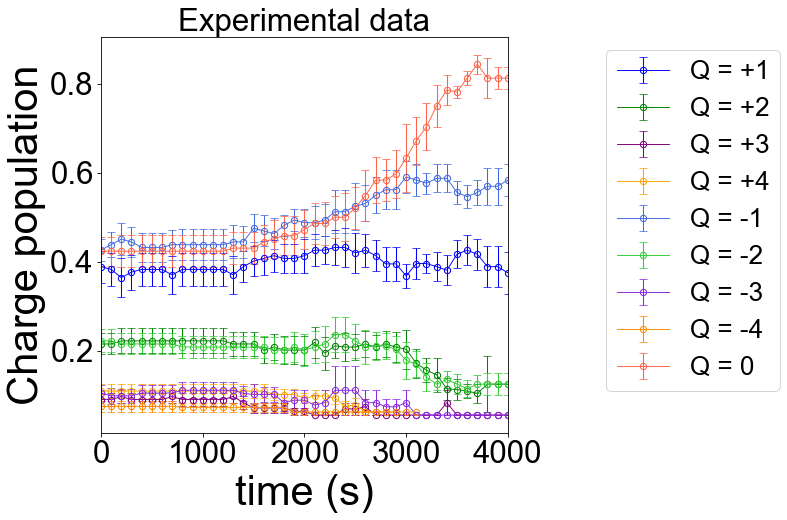

In [36]:
fig, ax1 = plt.subplots(figsize=(7,7))

#ax2 = ax1.twinx()



for typ_m, mtype in v_counts_m.groupby('type'):
    
    ax1.errorbar(mtype.index.get_level_values('frame'), mtype["fraction"],yerr = mtype["err"],dash_capstyle= 'butt',capsize=4,elinewidth = 1, linewidth = 0.9, capthick=0.7, ls = '-',fmt ='-o', fillstyle = 'none',label = typ_m)
    #ax1.errorbar(mtype.index.get_level_values('frame'), mtype["fraction"],yerr = mtype["err"], ls='--', marker='o', capsize=5, capthick=1, ecolor='black',label = typ_m)

    #ax1.plot(mtype.index.get_level_values('frame'), mtype["fraction"],'-', label = typ_m)

ax1.tick_params(axis='y', labelsize=30)
ax1.tick_params(axis='x', labelsize=30)  

ax1.legend(fontsize = 25, bbox_to_anchor=(1.7, 1))
ax1.set_xlabel('time (s)', size = 40)
ax1.set_ylabel('Charge population', size = 40)
ax1.set_title(f"Experimental data", size = 30)
ax1.set_xlim(0,4000)

#ax2.plot([0,2000,2500],[0,25,25],':', color = 'black', alpha = 0.5, lw = 5)


#ax2.set_ylabel('B (mT)', size = 40)
#ax2.tick_params(axis='y', labelsize=30)

#v_counts_m.to_csv('FreeBound.dat', sep = "\t")
plt.show()

In [17]:
coord4 = v_counts_m.query('coordination == 4')
coord3 = v_counts_m.query('coordination == 3')

Q = +2
Q = +4
Q = -2
Q = -4
Q = 0
Q = +1
Q = +3
Q = -1
Q = -3


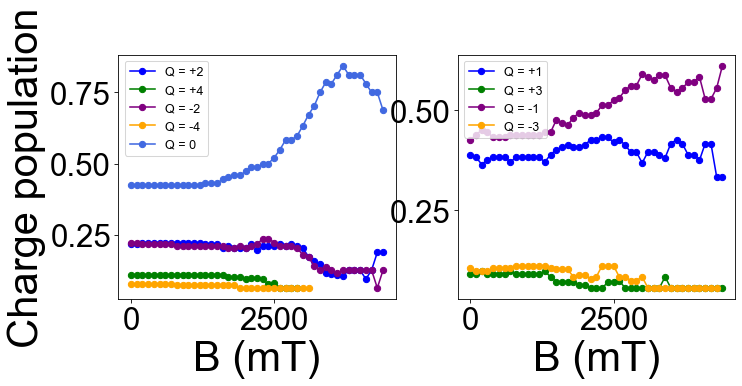

In [18]:
fig, ax = plt.subplots(1, 2,figsize=(10,5))

for typ_m, mtype in coord4.groupby('type'):
    print(typ_m)
    
    ax[0].errorbar(mtype.index.get_level_values("frame"), mtype["fraction"], fmt = '-o', label = typ_m)

for typ_m, mtype in coord3.groupby('type'):
    print(typ_m)
    ax[1].plot(mtype.index.get_level_values("frame"), mtype["fraction"],'-o',label = typ_m)

ax[0].tick_params(axis='y', labelsize=30)
ax[0].tick_params(axis='x', labelsize=30)  

ax[0].legend(fontsize = 12)
ax[0].set_xlabel('B (mT)', size = 40)
ax[0].set_ylabel('Charge population', size = 40)

ax[1].tick_params(axis='y', labelsize=30)
ax[1].tick_params(axis='x', labelsize=30)  

ax[1].legend(fontsize = 12)
ax[1].set_xlabel('B (mT)', size = 40)


plt.tight_layout()